# Futher explore
Here we will discuss 调整cutoff频率，  

In [22]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from utils import vis_hybrid_image, load_image, save_image, im_range
from student_code import my_imfilter, create_hybrid_image
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Two cutoff frequencies
It is suggested that different cutoff frequencies can be used to hybrid for a better effect.

We can set up different sigma by creating a new function.

In [23]:
def two_cutoff_frequency_hybrid(iamge1,image2,cutoff_frequency1,cutoff_frequency2):
    assert image1.shape[0] == image2.shape[0]
    assert image1.shape[1] == image2.shape[1]
    assert image1.shape[2] == image2.shape[2]


    filter1 = cv2.getGaussianKernel(cutoff_frequency1*4+1, cutoff_frequency1)
    filter1 = np.dot(filter1, filter1.T)

    filter2 = cv2.getGaussianKernel(cutoff_frequency2*4+1, cutoff_frequency2)
    filter2 = np.dot(filter2, filter2.T)

    low_frequencies= my_imfilter(image1, filter1)
    high_frequencies = image2 - my_imfilter(image2, filter2)

    hybrid_image = low_frequencies + high_frequencies

    return low_frequencies, high_frequencies, hybrid_image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4437142..1.2027217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5105022..1.180167].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55997956..1.1357822].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5632066..1.0552659].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5546951..0.9713092].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5265366..0.9044921].


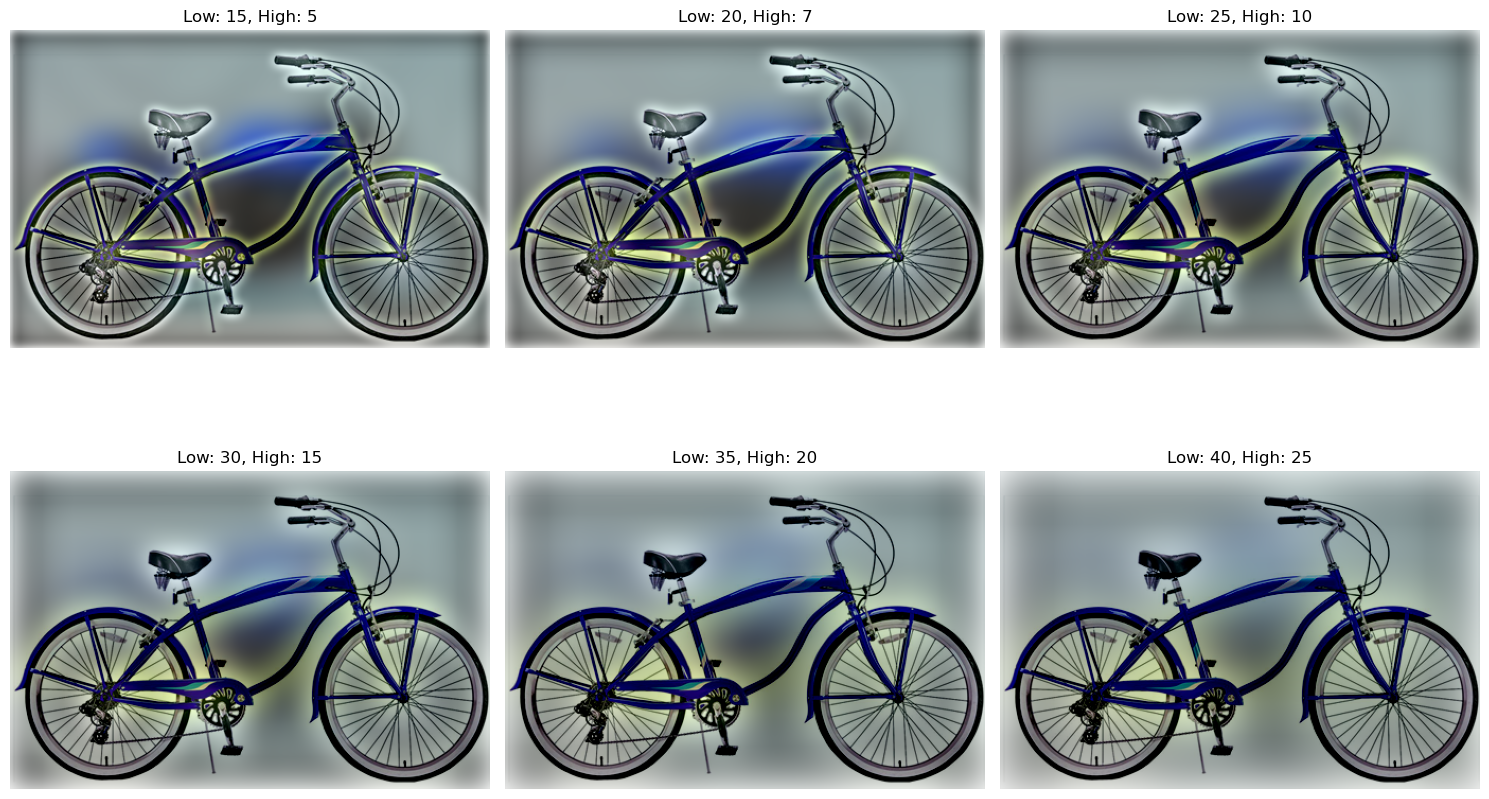

In [24]:
image1 = load_image('../data/motorcycle.bmp')
image2 = load_image('../data/bicycle.bmp')

# Carefully chosen frequency pairs for good fusion
frequency_pairs = [
    (15, 5),   # More Marilyn structure, subtle Einstein details
    (20, 7),   # Stronger Marilyn, slightly more Einstein details
    (25, 10),  # Marilyn dominant, balanced Einstein
    (30, 15),  # Even more Marilyn, moderate Einstein
    (35, 20),  # Marilyn very clear, Einstein still visible
    (40, 25),  # Marilyn strongly dominant, Einstein subtle
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()  # Flatten the 2D array of axes

# Generate and plot each hybrid image
for i, (cutoff1, cutoff2) in enumerate(frequency_pairs):
    _, _, hybrid = two_cutoff_frequency_hybrid(image1, image2, cutoff1, cutoff2)
    # Convert BGR to RGB for correct matplotlib display
    hybrid_rgb = cv2.cvtColor(hybrid, cv2.COLOR_BGR2RGB)
    axes[i].imshow(hybrid_rgb)
    axes[i].set_title(f'Low: {cutoff1}, High: {cutoff2}')
    axes[i].axis('off')  # Hide axes

# Adjust layout and display
plt.tight_layout()
plt.show()

The choice of cutoff frequencies in the hybrid image process significantly impacts the fusion of the motorcycle (image1) and bicycle (image2).

A smaller low-frequency cutoff (cutoff_frequency1) for the motorcycle, such as 3, heavily blurs its structure, retaining only its coarse shape (e.g., the overall outline), making it dominant at a distance while allowing the bicycle’s high-frequency details to stand out up close; 

conversely, a larger low-frequency cutoff like 20 preserves more of the motorcycle’s mid-level details (e.g., frame shape, wheels), causing it to dominate even at closer ranges.
 
On the other hand, a smaller high-frequency cutoff (cutoff_frequency2) for the bicycle, such as 5, suppresses its fine details (e.g., spokes, handlebars), making them barely visible, while a larger high-frequency cutoff like 40 retains more of these details, ensuring they are prominent up close but potentially overwhelmed by the motorcycle’s low frequencies if the latter’s cutoff is too high. 

For example, with a pair like (3, 15), the motorcycle appears as a blurry shape at a distance, while the bicycle’s details (e.g., pedals, textures) emerge clearly up close; in contrast, a pair like (20, 40) makes the motorcycle’s structure much clearer even at moderate distances, with the bicycle’s details still visible but less pronounced due to the motorcycle’s stronger low-frequency contribution, creating a gradual shift in balance across the frequency pairs.

# Kernel types
Apart from gaussian kernel, we can also use different types of kernels to inplement the hybridation.

Here we can give it a shot to box blur kernel, laplacian kernel, and even asymmetric kernel.

In [25]:
def create_box_filter(height, width):
    assert height % 2 == 1 and width % 2 == 1

    kernel=np.ones((height, width), np.float32)
    kernel=kernel/np.sum(kernel)
    return kernel

In [26]:
def create_laplacian_filter(height, width):
    assert height % 2 == 1 and width % 2 == 1

    kernel = np.zeros((height, width), dtype=np.float32)
    center_y = height // 2
    center_x = width // 2
    
    for i in range(height):
        for j in range(width):
            if i == center_y and j == center_x:
                kernel[i, j] = -4  # 中心点
            elif (i == center_y and abs(j - center_x) == 1) or (j == center_x and abs(i - center_y) == 1):
                kernel[i, j] = 1  # 十字方向上的相邻点
    
    return kernel

The create_asymmetric_filter function generates a 2D filter kernel that performs weighted smoothing along the horizontal direction: the center column has the highest weight (1), decreasing linearly to 0 on both sides (forming a triangular distribution), while the weights remain uniform in the vertical direction.

In [27]:
def create_asymmetric_filter(height, width):
    assert height % 2 == 1 and width % 2 == 1
    
    kernel = np.ones((height, width), dtype=np.float32)
    center_x = width // 2
    
    # 沿水平方向线性递减
    for x in range(width):
        distance = abs(x - center_x)
        kernel[:, x] *= (1 - distance / (width / 2))  # 从中心向两侧递减
    
    kernel /= np.sum(kernel)
    return kernel

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.045756303..1.0802159].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.046818748..1.0275309].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.33725494..1.7176471].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04645375..1.0235742].


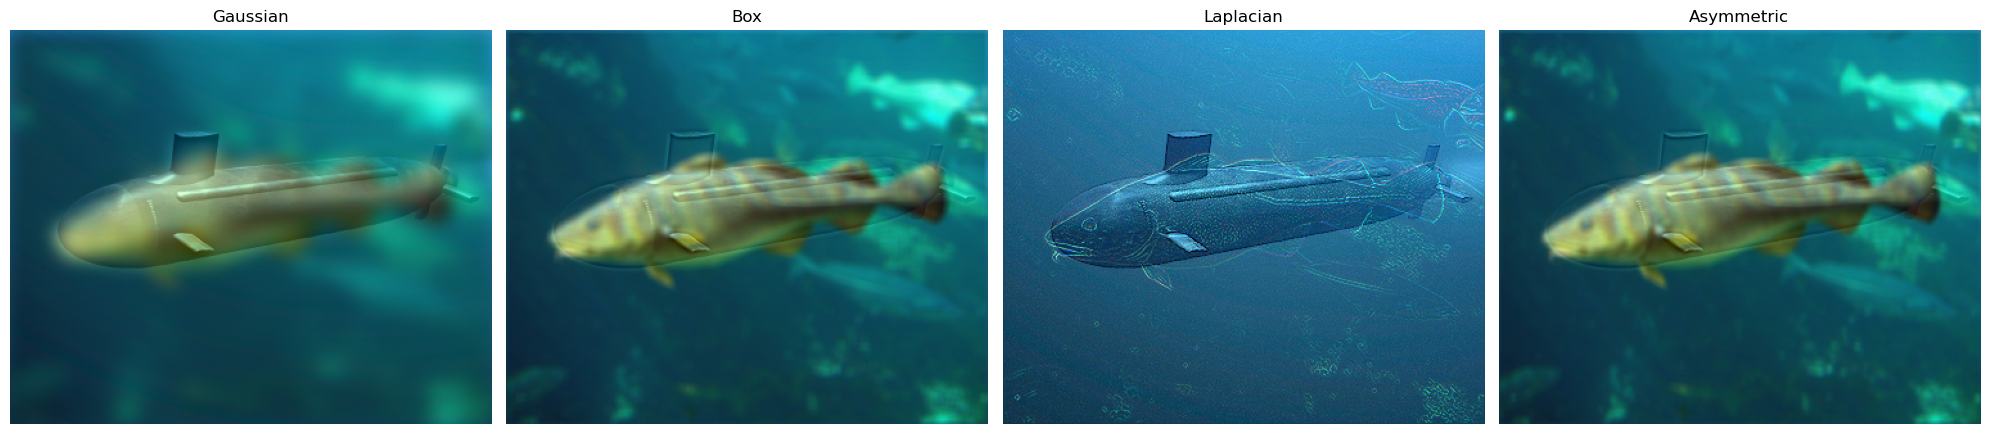

In [32]:
image1 = load_image('../data/fish.bmp')
image2 = load_image('../data/submarine.bmp')


filter1 = cv2.getGaussianKernel(ksize=7*4+1,sigma=7)
filter1 = np.dot(filter1,filter1.T)

filter2=create_box_filter(7,7)
filter3=create_laplacian_filter(7,7)
filter4=create_asymmetric_filter(7,7)

_,_,hybrid_image1 = create_hybrid_image(image1, image2, filter1)
_,_,hybrid_image2 = create_hybrid_image(image1, image2, filter2)
_,_,hybrid_image3 = create_hybrid_image(image1, image2, filter3)
_,_,hybrid_image4 = create_hybrid_image(image1, image2, filter4)


fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes = axes.ravel()  

axes[0].imshow(hybrid_image1)
axes[0].set_title('Gaussian')
axes[0].axis('off')

axes[1].imshow(hybrid_image2)
axes[1].set_title('Box')
axes[1].axis('off')

axes[2].imshow(hybrid_image3)
axes[2].set_title('Laplacian')
axes[2].axis('off')

axes[3].imshow(hybrid_image4)
axes[3].set_title('Asymmetric')
axes[3].axis('off')

plt.tight_layout()


# Filter Characteristics Based on Hybrid Images

- **Gaussian**  
  A low-pass filter that smooths the image, retaining low-frequency information (submarine structure) while suppressing high-frequency details (fish texture). The submarine dominates, with fish details barely visible.

- **Box**  
  A uniform low-pass filter that averages pixel values, smoothing the image. The submarine structure is prominent, but more fish details are visible compared to Gaussian due to less aggressive smoothing.

- **Laplacian**  
  A high-pass filter that enhances high-frequency information (edges, details). The fish's edges and texture are more visible, while the submarine's low-frequency structure remains dominant but slightly weakened.

- **Asymmetric**  
  A directional low-pass filter that smooths horizontally (center weight 1, decreasing to 0 at edges) while preserving vertical details. The fish's vertical high-frequency details are prominent, and the submarine's horizontal structure is weakened.